In [1]:
from newsapi import NewsApiClient
from transformers import pipeline
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
newsapi = NewsApiClient(api_key="ac5c0af95ff04d33a9045de471aa2de4")
sentiment_model = pipeline("sentiment-analysis")
ticker = "NVDA"
company = "Nvidia"

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
articles = newsapi.get_everything(
    q=company, language="en", sort_by="relevancy", page_size=100
)
news = pd.DataFrame([
    {"headline": a["title"], "date": a["publishedAt"][:10]}
    for a in articles["articles"]
])
news["score"] = news["headline"].apply(
    lambda x: sentiment_model(x)[0]["score"] * 
              (1 if sentiment_model(x)[0]["label"] == "POSITIVE" else -1)
)

In [4]:
daily_sentiment = news.groupby("date")["score"].mean().reset_index()
daily_sentiment.rename(columns={"score": "avg_sentiment_score"}, inplace=True)

In [5]:
stocks = yf.download(ticker, period="1mo", interval="1d").reset_index()
stocks["date"] = stocks["Date"].dt.strftime("%Y-%m-%d")
stocks["return"] = ((stocks["Close"] - stocks["Open"]) / stocks["Open"] * 100)


[*********************100%***********************]  1 of 1 completed


In [6]:
data = pd.merge(daily_sentiment, stocks, on="date") # merging sentiment and stock data

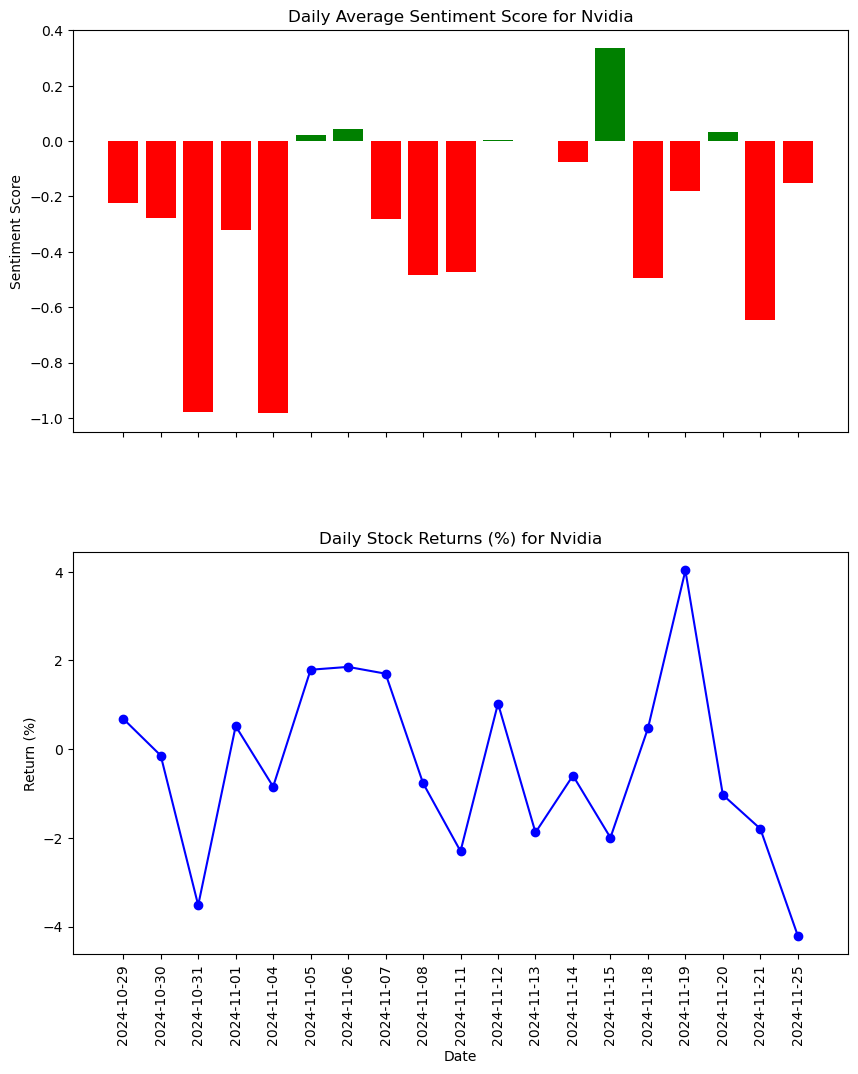

In [8]:
# %% Plot Sentiment and Stock Data
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True, 
                         gridspec_kw={"hspace": 0.3})

# Sentiment Scores
axes[0].bar(data["date"], data["avg_sentiment_score"], 
            color=["green" if s > 0 else "red" for s in data["avg_sentiment_score"]])
axes[0].set_title(f"Daily Average Sentiment Score for {company}")
axes[0].set_ylabel("Sentiment Score")
axes[0].tick_params(axis="x", rotation=90)

# Stock Returns
axes[1].plot(data["date"], data["return"], color="blue", marker="o")
axes[1].set_title(f"Daily Stock Returns (%) for {company}")
axes[1].set_ylabel("Return (%)")
axes[1].set_xlabel("Date")
axes[1].tick_params(axis="x", rotation=90)
plt.show()